In [0]:
import pyspark.sql.functions as f
from pyspark.sql.window import Window
from pyspark.sql import SparkSession

In [0]:
# Load the Delta table from yelp data table format conversion
df_review_delta = spark.sql("SELECT * FROM global_temp.df_review_delta_global_temp_view")
df_review_delta.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [0]:
## Fake review Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline

In [0]:
# Convert the DeltaTable to a pandas DataFrame
review_df = df_review_delta.toPandas()

In [0]:
# SHAPE OF THE DATASET
print("Shape of the dataset:")
print(review_df.shape)
# COLUMN NAMES
print("Column names:")
print(review_df.columns)
# DATATYPE OF EACH COLUMN
print("Datatype of each column:")
print(review_df.dtypes)
# SEEING FEW OF THE ENTRIES
print("Few dataset entries:")
print(review_df.head())
# DATASET SUMMARY
review_df.describe(include='all')

Shape of the dataset:
(22500, 9)
Column names:
Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id'],
      dtype='object')
Datatype of each column:
business_id     object
cool             int64
date            object
funny            int64
review_id       object
stars          float64
text            object
useful           int64
user_id         object
dtype: object
Few dataset entries:
              business_id  cool  ... useful                 user_id
0  0l_njS4wGMadAk1b4nZRUA     0  ...      0  KzZIsBoZvhgL70be88CfSQ
1  qhsJbgxVNDb0973r3Gjrow     1  ...      3  qOAYy-WGn54j7LyiqKU-OQ
2  F87os-6oNyUAEeGxQJKFkw     0  ...      2  3-MUKEqZtyEJ8iZK2B2kDw
3  WKF4p8kLDng4EECYC3RoeQ     0  ...      0  r6GXrPswAqNuPf6u4hkWwg
4  UCMSWPqzXjd7QHq7v8PJjQ     0  ...      0  azJSQWKdhUCsFELul6sVnQ

[5 rows x 9 columns]


,business_id,cool,date,funny,review_id,stars,text,useful,user_id
count,22500,22500.000000,22500,22500.000000,22500,22500.000000,22500,22500.000000,22500
unique,5836,NaN,22485,NaN,22500,NaN,22498,NaN,20371
top,GBTPC53ZrG1ZBY3DT8Mbcw,NaN,2016-03-07 01:32:03,NaN,J1pUbFc50BkXgOHDX3i1vw,NaN,I'm very displeased with my experience here th...,NaN,_BcWyKQL16ndpBdggh2kNA
freq,214,NaN,2,NaN,1,NaN,2,NaN,13
mean,NaN,0.340178,NaN,0.252444,NaN,3.853156,NaN,0.883644,NaN
std,NaN,1.053489,NaN,0.937965,NaN,1.347667,NaN,1.924198,NaN
min,NaN,0.000000,NaN,0.000000,NaN,1.000000,NaN,0.000000,NaN
25%,NaN,0.000000,NaN,0.000000,NaN,3.000000,NaN,0.000000,NaN
50%,NaN,0.000000,NaN,0.000000,NaN,4.000000,NaN,0.000000,NaN
75%,NaN,0.000000,NaN,0.000000,NaN,5.000000,NaN,1.000000,NaN


In [0]:
# Filter out rows where 'text' is None
review_df = review_df.dropna(subset=['text'])

# CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
review_df['length'] = review_df['text'].apply(len)

# Print the first few rows of the updated DataFrame
review_df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,length
0,0l_njS4wGMadAk1b4nZRUA,0,2016-03-31 11:45:51,0,J1pUbFc50BkXgOHDX3i1vw,5.0,I pretty much never write a review but I have ...,0,KzZIsBoZvhgL70be88CfSQ,365
1,qhsJbgxVNDb0973r3Gjrow,1,2013-11-14 03:03:44,0,Zran1HOTZchIbOHAVaYXqQ,5.0,I really can't think of anything bad to say ab...,3,qOAYy-WGn54j7LyiqKU-OQ,1670
2,F87os-6oNyUAEeGxQJKFkw,0,2016-10-27 04:39:16,1,plYo9yNuPsO181zFfRAwFA,4.0,Worth a try.\n\nTwo of us went there for dinne...,2,3-MUKEqZtyEJ8iZK2B2kDw,640
3,WKF4p8kLDng4EECYC3RoeQ,0,2018-06-27 01:02:48,0,b63fKVpSmWoJDRpRQb8hcA,5.0,We had a gift card and came on a Tuesday night...,0,r6GXrPswAqNuPf6u4hkWwg,237
4,UCMSWPqzXjd7QHq7v8PJjQ,0,2017-09-09 19:52:02,0,w5Yw7JwKF4hj0gED7pFDsA,5.0,My favorite spot for brunch and lunch! Be prep...,0,azJSQWKdhUCsFELul6sVnQ,245


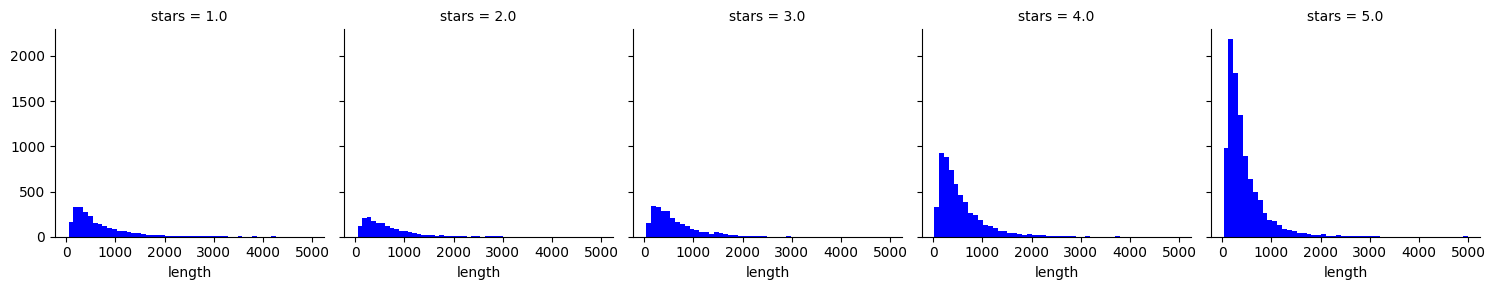

In [0]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=review_df,col='stars')
graph.map(plt.hist,'length',bins=50,color='blue')

In [0]:
# GETTING THE MEAN VALUES OF THE VOTE COLUMNS WRT THE STARS ON THE REVIEW
stval = review_df.groupby('stars').mean()
stval

,cool,funny,useful,length
stars,,,,
1.0,0.146645,0.461475,1.371168,698.643745
2.0,0.217317,0.377476,1.084890,676.516129
3.0,0.290437,0.283747,0.811098,638.056277
4.0,0.444059,0.254987,0.853426,564.514657
5.0,0.361330,0.170578,0.766404,455.007091


In [0]:
# FINDING THE CORRELATION BETWEEN THE VOTE COLUMNS
stval.corr()

,cool,funny,useful,length
cool,1.000000,-0.856313,-0.835747,-0.769331
funny,-0.856313,1.000000,0.947495,0.927679
useful,-0.835747,0.947495,1.000000,0.759679
length,-0.769331,0.927679,0.759679,1.000000


In [0]:
# CLASSIFICATION
data_classes = review_df[(review_df['stars']==1) | (review_df['stars']==3) | (review_df['stars']==5)]
print(data_classes.shape)
data_classes.head()

(14968, 10)


,business_id,cool,date,funny,review_id,stars,text,useful,user_id,length
0,0l_njS4wGMadAk1b4nZRUA,0,2016-03-31 11:45:51,0,J1pUbFc50BkXgOHDX3i1vw,5.0,I pretty much never write a review but I have ...,0,KzZIsBoZvhgL70be88CfSQ,365
1,qhsJbgxVNDb0973r3Gjrow,1,2013-11-14 03:03:44,0,Zran1HOTZchIbOHAVaYXqQ,5.0,I really can't think of anything bad to say ab...,3,qOAYy-WGn54j7LyiqKU-OQ,1670
3,WKF4p8kLDng4EECYC3RoeQ,0,2018-06-27 01:02:48,0,b63fKVpSmWoJDRpRQb8hcA,5.0,We had a gift card and came on a Tuesday night...,0,r6GXrPswAqNuPf6u4hkWwg,237
4,UCMSWPqzXjd7QHq7v8PJjQ,0,2017-09-09 19:52:02,0,w5Yw7JwKF4hj0gED7pFDsA,5.0,My favorite spot for brunch and lunch! Be prep...,0,azJSQWKdhUCsFELul6sVnQ,245
5,pym7c6ZFEtmoH16xN2ApBg,0,2013-10-03 22:45:27,1,lVrDdmBYZwyfoEhsnNGyzA,5.0,I wish I'd checked into this place to prove my...,1,UgwrOTJyTYkOnKWNejGaUg,482


In [0]:
# Seperate the dataset into X and Y for prediction
x = data_classes['text']
y = data_classes['stars']
print(x.head())
print(y.head())

0    I pretty much never write a review but I have ...
1    I really can't think of anything bad to say ab...
3    We had a gift card and came on a Tuesday night...
4    My favorite spot for brunch and lunch! Be prep...
5    I wish I'd checked into this place to prove my...
Name: text, dtype: object
0    5.0
1    5.0
3    5.0
4    5.0
5    5.0
Name: stars, dtype: float64


In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# CLEANING THE REVIEWS - REMOVAL OF STOPWORDS AND PUNCTUATION
stopwords = stopwords.words('english')
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords]

In [0]:
# CONVERTING THE WORDS INTO A VECTOR

vocab = CountVectorizer(analyzer=text_process).fit(x)
print(len(vocab.vocabulary_))
r0 = x[0]
print(r0)
vocab0 = vocab.transform([r0])
print(vocab0)
"""
    Now the words in the review number 78 have been converted into a vector.
    The data that we can see is the transformed words.
    If we now get the feature's name - we can get the word back!
"""
print("Getting the words back:")
print(vocab.get_feature_names()[19648])
print(vocab.get_feature_names()[10643])

42623
I pretty much never write a review but I have been using this Panera for almost two years now. Not consistently but a couple times a month and the staff/service is always excellent. Everything is always fresh and my order is correct. They do a great job making a large company feel like a mom and pop shop. Not to mention Panera has the absolutely best bagels ever.
  (0, 5529)	1
  (0, 10779)	2
  (0, 15683)	1
  (0, 16227)	1
  (0, 16268)	2
  (0, 17182)	1
  (0, 17690)	1
  (0, 20315)	1
  (0, 20578)	1
  (0, 20813)	1
  (0, 20910)	1
  (0, 23683)	1
  (0, 23758)	1
  (0, 24282)	1
  (0, 25097)	1
  (0, 25978)	1
  (0, 28291)	1
  (0, 28764)	1
  (0, 29080)	1
  (0, 29597)	1
  (0, 30093)	1
  (0, 30569)	1
  (0, 30620)	1
  (0, 30768)	1
  (0, 31122)	1
  (0, 31910)	1
  (0, 33467)	1
  (0, 33826)	1
  (0, 35444)	1
  (0, 36875)	1
  (0, 38116)	1
  (0, 39811)	1
  (0, 40516)	1
  (0, 41058)	1
  (0, 42344)	1
  (0, 42436)	1
Getting the words back:
chimichangas
PLAGUE


/databricks/python/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [0]:
x = vocab.transform(x)
#Shape of the matrix:
print("Shape of the sparse matrix: ", x.shape)
#Non-zero occurences:
print("Non-Zero occurences: ",x.nnz)

# DENSITY OF THE MATRIX
density = (x.nnz/(x.shape[0]*x.shape[1]))*100
print("Density of the matrix = ",density)

Shape of the sparse matrix:  (14968, 42623)
Non-Zero occurences:  653760
Density of the matrix =  0.10247326086781786


In [0]:
# SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

# Print the first 5 rows of each matrix
print(x_train[:5])
print(x_test[:5])
print(y_train[:5])
print(y_test[:5])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

  (0, 6620)	1
  (0, 16567)	1
  (0, 17150)	1
  (0, 18598)	1
  (0, 18663)	3
  (0, 18670)	1
  (0, 19358)	1
  (0, 23161)	1
  (0, 24498)	1
  (0, 25147)	1
  (0, 25276)	1
  (0, 25370)	1
  (0, 25709)	1
  (0, 27025)	1
  (0, 29348)	1
  (0, 29526)	1
  (0, 30100)	1
  (0, 31193)	1
  (0, 31726)	1
  (0, 31910)	1
  (0, 32536)	1
  (0, 33385)	1
  (0, 37016)	1
  (0, 37995)	1
  (0, 38750)	1
  :	:
  (4, 23194)	1
  (4, 24731)	1
  (4, 25194)	1
  (4, 25224)	1
  (4, 25564)	1
  (4, 25709)	1
  (4, 25767)	1
  (4, 25842)	1
  (4, 26373)	1
  (4, 27094)	1
  (4, 27235)	1
  (4, 27494)	1
  (4, 28083)	1
  (4, 28843)	1
  (4, 29296)	1
  (4, 29928)	1
  (4, 31387)	1
  (4, 31769)	2
  (4, 32555)	1
  (4, 32622)	1
  (4, 33931)	1
  (4, 35711)	2
  (4, 36917)	1
  (4, 36953)	1
  (4, 38512)	1
  (0, 15870)	1
  (0, 16268)	1
  (0, 16828)	1
  (0, 19129)	1
  (0, 20095)	2
  (0, 20561)	1
  (0, 21052)	1
  (0, 21534)	1
  (0, 22521)	1
  (0, 23194)	1
  (0, 23903)	1
  (0, 25097)	2
  (0, 25136)	1
  (0, 25719)	1
  (0, 26394)	1
  (0, 27157)	1
  (0,

In [0]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train,y_train)
predmnb = mnb.predict(x_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[ 387   89   33]
 [  46  234  201]
 [  58   53 1893]]
Score: 83.97
Classification Report:               precision    recall  f1-score   support

         1.0       0.79      0.76      0.77       509
         3.0       0.62      0.49      0.55       481
         5.0       0.89      0.94      0.92      2004

    accuracy                           0.84      2994
   macro avg       0.77      0.73      0.75      2994
weighted avg       0.83      0.84      0.83      2994



In [0]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(x_train,y_train)
predrmfr = rmfr.predict(x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:",classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[ 261   25  223]
 [  20   59  402]
 [   6    7 1991]]
Score: 77.19
Classification Report:               precision    recall  f1-score   support

         1.0       0.91      0.51      0.66       509
         3.0       0.65      0.12      0.21       481
         5.0       0.76      0.99      0.86      2004

    accuracy                           0.77      2994
   macro avg       0.77      0.54      0.57      2994
weighted avg       0.77      0.77      0.72      2994



In [0]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
preddt = dt.predict(x_test)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,preddt))
print("Score:",round(accuracy_score(y_test,preddt)*100,2))
print("Classification Report:",classification_report(y_test,preddt))

Confusion Matrix for Decision Tree:
[[ 291   84  134]
 [  83  174  224]
 [ 116  175 1713]]
Score: 72.75
Classification Report:               precision    recall  f1-score   support

         1.0       0.59      0.57      0.58       509
         3.0       0.40      0.36      0.38       481
         5.0       0.83      0.85      0.84      2004

    accuracy                           0.73      2994
   macro avg       0.61      0.60      0.60      2994
weighted avg       0.72      0.73      0.72      2994



In [0]:
# Support Vector Machine
from sklearn.svm import SVC
svm = SVC(random_state=101)
svm.fit(x_train,y_train)
predsvm = svm.predict(x_test)
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(y_test,predsvm))
print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:",classification_report(y_test,predsvm))

Confusion Matrix for Support Vector Machines:
[[ 327   39  143]
 [  27  188  266]
 [  16   35 1953]]
Score: 82.43
Classification Report:               precision    recall  f1-score   support

         1.0       0.88      0.64      0.74       509
         3.0       0.72      0.39      0.51       481
         5.0       0.83      0.97      0.89      2004

    accuracy                           0.82      2994
   macro avg       0.81      0.67      0.71      2994
weighted avg       0.82      0.82      0.81      2994



In [0]:
from sklearn.ensemble import GradientBoostingClassifier
"""# parameter evaluation
gbe = GradientBoostingClassifier(random_state=0)
parameters = {
     'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.5, 1],
    'max_depth': [3, 4, 5]}
gridsearch=GridSearchCV(gbe,parameters,cv=100,scoring='roc_auc')
gridsearch.fit(x,y)
print(gridsearch.best_params_)
print(gridsearch.best_score_)"""
#Boosting
gbi = GradientBoostingClassifier(learning_rate=0.1,max_depth=5,max_features=0.5,random_state=999999)
gbi.fit(x_train,y_train)
predgbi = gbi.predict(x_test)
print("Confusion Matrix for Gradient Boosting Classifier:")
print(confusion_matrix(y_test,predgbi))
print("Score:",round(accuracy_score(y_test,predgbi)*100,2))
print("Classification Report:",classification_report(y_test,predgbi))

Confusion Matrix for Gradient Boosting Classifier:
[[ 310   56  143]
 [  31  175  275]
 [  11   41 1952]]
Score: 81.4
Classification Report:               precision    recall  f1-score   support

         1.0       0.88      0.61      0.72       509
         3.0       0.64      0.36      0.46       481
         5.0       0.82      0.97      0.89      2004

    accuracy                           0.81      2994
   macro avg       0.78      0.65      0.69      2994
weighted avg       0.80      0.81      0.79      2994



In [0]:
# K Nearest Neighbour Algorithm
import warnings
from sklearn.neighbors import KNeighborsClassifier

# Ignore the warning
warnings.filterwarnings("ignore", message="FutureWarning: .*keepdims.*")

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train,y_train)
predknn = knn.predict(x_test)
print("Confusion Matrix for K Neighbors Classifier:")
print(confusion_matrix(y_test,predknn))
print("Score: ",round(accuracy_score(y_test,predknn)*100,2))
print("Classification Report:")
print(classification_report(y_test,predknn))

/databricks/python/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/databricks/python/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

Confusion Matrix for K Neighbors Classifier:
[[  77   12  420]
 [   2   16  463]
 [   1    4 1999]]
Score:  69.87
Classification Report:
              precision    recall  f1-score   support

         1.0       0.96      0.15      0.26       509
         3.0       0.50      0.03      0.06       481
         5.0       0.69      1.00      0.82      2004

    accuracy                           0.70      2994
   macro avg       0.72      0.39      0.38      2994
weighted avg       0.71      0.70      0.60      2994



In [0]:
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train,(y_train-1)/2)
predxgb = xgb.predict(x_test)
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,(predxgb*2)+1))
print("Score: ",round(accuracy_score(y_test,(predxgb*2)+1)*100,2))
print("Classification Report:")
print(classification_report(y_test,(predxgb*2)+1))

Confusion Matrix for XGBoost Classifier:
[[ 368   59   82]
 [  29  228  224]
 [  20   51 1933]]
Score:  84.47
Classification Report:
              precision    recall  f1-score   support

         1.0       0.88      0.72      0.79       509
         3.0       0.67      0.47      0.56       481
         5.0       0.86      0.96      0.91      2004

    accuracy                           0.84      2994
   macro avg       0.81      0.72      0.75      2994
weighted avg       0.84      0.84      0.83      2994



In [0]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)
predmlp = mlp.predict(x_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[ 412   60   37]
 [  60  261  160]
 [  34   77 1893]]
Score: 85.7
Classification Report:
              precision    recall  f1-score   support

         1.0       0.81      0.81      0.81       509
         3.0       0.66      0.54      0.59       481
         5.0       0.91      0.94      0.92      2004

    accuracy                           0.86      2994
   macro avg       0.79      0.77      0.78      2994
weighted avg       0.85      0.86      0.85      2994



In [0]:
# POSITIVE REVIEW
# get the predicted ratings for the entire training set
pred_mlp_x = mlp.predict(x)

# create a new DataFrame with the predicted ratings
ratings_df = pd.DataFrame({'actual_ratings': y, 'predicted_ratings': pred_mlp_x})

# print the confusion matrix, accuracy score, and classification report
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y,pred_mlp_x))
print("Score:",round(accuracy_score(y,pred_mlp_x)*100,2))
print("Classification Report:")
print(classification_report(y,pred_mlp_x))

Confusion Matrix for Multilayer Perceptron Classifier:
[[2317   60   37]
 [  60 2321  160]
 [  34   77 9902]]
Score: 97.14
Classification Report:
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96      2414
         3.0       0.94      0.91      0.93      2541
         5.0       0.98      0.99      0.98     10013

    accuracy                           0.97     14968
   macro avg       0.96      0.95      0.96     14968
weighted avg       0.97      0.97      0.97     14968



In [0]:
# POSITIVE REVIEW
pr = review_df['text'][1]
print(pr)
print("Actual Rating: ",review_df['stars'][1])
pr_t = vocab.transform([pr])
print("Predicted Rating:", mlp.predict(pr_t)[0])

I really can't think of anything bad to say about this place! I have eaten there twice and verbally (and loudly) moaned in food pleasure over each meal!

Meal One:
We Appz'd on the Assorted Breads.  Safe choice, but wonderful selections!
My dinner entree was the Amish Chicken. Very tender and juicy and the potato hash was wonderful!

Meal Two:
The Appz was the Potted Pig, and the Flash Fried Brussels Sprouts.
The potted pig was plated creatively having to use a spoon to dive into the pork (texture of a country pate) and then add your toppings from the pickled selections of veggies they gave you either on a cracker or bread.  It was good.... BUT

If you REALLY want a surprising treat, get the Flash Fried Brussels Sprouts! Holy YUM. If Brussels Spouts could ever be considered candy.... you found it here.  They flash fry them and put them in a dish with onions, almonds and bacon! What a TREAT! 

I chose (after tasting my buddies last visit) the Pork Chop. And I remembered correctly, it wa

In [0]:
# AVERAGE REVIEW
ar = review_df['text'][10647]
print(ar)
print("Actual Rating: ",review_df['stars'][10647])
ar_t = vocab.transform([ar])
print("Predicted Rating:",mlp.predict(ar_t)[0])

Confusing menu. Too many nicknames and gimmicks. Service was very slow. Steak was dry and overly chopped. Roll was awesome. Place was clean and they ha a dog bowl with water and treats. So three stars instead of two.  Cheesesteak time warp if your coming from city.
Actual Rating:  3.0
Predicted Rating: 3.0


In [0]:
# NEGATIVE REVIEW
nr = review_df['text'][21349]
print(nr)
print("Actual Rating: ",review_df['stars'][21349])
nr_t = vocab.transform([nr])
print("Predicted Rating:", mlp.predict(nr_t)[0])

Frankly, The Dish was one of my very special favorite small restaurants in Tucson before they moved across the street. Now it seems the restaurant owners can't decide whether to be a restaurant or an appetizer bar. I don't think they can have it both ways, especially with rude servers, cold  food and multiple mistakes in the plate orders. OK, perhaps it was an off night. I have plenty of those myself. At least they only burnt two of the steaks, as the other two orders were fish and shellfish.But it made me long for the days of The Dish before this last  disastrous move.
Actual Rating:  1.0
Predicted Rating: 1.0


In [0]:
count = review_df['stars'].value_counts()
print(count)

5.0    10013
4.0     5765
3.0     2541
1.0     2414
2.0     1767
Name: stars, dtype: int64
